# Aeolus preliminary HLOS (L1B)
## Aeolus Level 1B product - preliminary horizontal line-of-sight wind observations and useful signals

> Abstract: Access to level 1B product and its visualization

In [1]:
%load_ext blackcellmagic
# Enable following line for interactive plots
# %matplotlib widget
%load_ext watermark
%watermark -i -v -p viresclient,pandas,xarray,matplotlib

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.22.0

viresclient: 0.9.1
pandas     : 1.2.4
xarray     : 0.17.0
matplotlib : 3.4.1



## Load packages and modules

In [2]:
from viresclient import AeolusRequest
import datetime as dt
import numpy as np
from netCDF4 import num2date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as feat
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

## Product information

The Level 1B wind product of the Aeolus mission contains the preliminary HLOS (horizontal line-of-sight) wind observations and useful signals for Rayleigh and Mie receivers, which are generated in Near Real Time (NRT) within 3 hours after data acquisition. Standard atmospheric correction (Rayleigh channel), receiver response and bias correction is applied. 

Documentation:
- https://earth.esa.int/eogateway/catalog/aeolus-preliminary-hlos-horizontal-line-of-sight-wind-observations-for-rayleigh-and-mie-receivers



### L1B parameters on VirES

Many of the parameters of the L1B product can be obtained from the viresclient. A list of selected parameters can be found in the following table. For a complete list, please refer to the web client which lists the available parameters under the "Data" tab. For an explanation of the parameters, please refer to the VirES web client or the documentation (link above).
Some parameters are available specifically for Rayleigh or Mie measurements (e.g. HLOS winds), others are independent of the measurement method and universally applicable (e.g. time). There is also a distinction between observations and measurements, with 30 measurements being averaged to one observation. A description of the parameters in the table is shown as tooltip when hovering the parameter name.

| Parameter | Observation type <br> Rayleigh | Observation type <br> Mie | Observation type <br> independent | Granularity <br> observation | Granularity <br> measurement |
|:----------|:------------------------------:|:-------------------------:|:--------------------------:|:----------------------------:|:----------------------------:|
|[time](## "UTC Time at center of obs/meas")              |   |   | X | X | X |
|[altitude](## "Altitude of height bins with respect to the WGS84 ellipsoid along the line-of-sight")          | X | X |   | X | X |
|[latitude](## "Latitude of each height bin along the line-of-sight")          | X | X |   | X | X |
|[longitude](## "Longitude of each height bin along the line-of-sight")         | X | X |   | X | X |
|[range](## "Distance along the LOS between the instrument and the lower edge of the height bin")             | X | X |   | X |   |
|[HLOS_wind_speed](## "Vertical profiles of HLOS winds")   | X | X |   | X | X |
|[signal_intensity](## "Vertical profiles of signal intensity")  | X | X |   | X | X |
|[signal_channel_A_intensity](## "Vertical profiles of signal intensity of Rayleigh channel A") | X |   |   | X | X |
|[signal_channel_B_intensity](## "Vertical profiles of signal intensity of Rayleigh channel B") | X |   |   | X | X |
|[SNR](## "Vertical profiles of signal-to-noise ratio")               | X | X |   | X | X |
|[channel_A_SNR](## "Vertical profiles of signal-to-noise for the Rayleigh channel A")     | X |   |   | X | X |
|[channel_B_SNR](## "Vertical profiles of signal-to-noise for the Rayleigh channel B")     | X |   |   | X | X |
|[bin_quality_flag](## "Bin quality flag")  | X | X |   | X | X |
|[geoid_separation](## "Height of geoid above WGS84 ellipsoid")  |   |   | X | X | X |
|[scattering_ratio](## "Vertical profiles of the scattering ratio for the Mie channel")  |   | X |   | X | X |
|[average_laser_energy](## "Average laser pulse UV energy of N * (P – 1) pulses") |   |   | X | X | X |

## Defining product, parameters and time for the data request
Keep in mind that the time for **one full orbit** is aorund **90 minutes**.
The **repeat cycle** of the orbits is **7 days**.

In [3]:
# Aeolus product
DATA_PRODUCT = "ALD_U_N_1B"

# measurement period in yyyy-mm-ddTHH:MM:SS
measurement_start = "2020-10-20T00:00:00Z"
measurement_stop = "2020-10-20T02:00:00Z"

# Product parameters to retrieve
# uncomment parameters of interest

# Rayleigh observation level
parameter_rayleigh_observations = [
    "altitude",
    "latitude",
    "longitude",
    "range",
    # "HLOS_wind_speed",
    "signal_intensity",
    # "signal_intensity_normalised",
    # "signal_channel_A_intensity",
    # "signal_channel_B_intensity",
    "bin_quality_flag",
    "SNR",
]
parameter_rayleigh_observations = ["rayleigh_" + param for param in parameter_rayleigh_observations]

# Rayleigh measurement level
parameter_rayleigh_measurements = [
    "altitude",
    # "latitude",
    # "longitude",
    # "HLOS_wind_speed",
    "signal_intensity",
    # "signal_intensity_normalised",
    # "signal_channel_A_intensity",
    # "signal_channel_B_intensity",
    "bin_quality_flag",
    # "SNR",
]
parameter_rayleigh_measurements = ["rayleigh_" + param for param in parameter_rayleigh_measurements]

# Mie observation level
parameter_mie_observations = [
    "altitude",
    "latitude",
    "longitude",
    "range",
    # "HLOS_wind_speed",
    "signal_intensity",
    # "signal_intensity_normalised",
    "bin_quality_flag",
    "SNR",
]
parameter_mie_observations = ["mie_" + param for param in parameter_mie_observations]

# Mie measurement level
parameter_mie_measurements = [
    "altitude",
    # "latitude",
    # "longitude",
    # "HLOS_wind_speed",
    "signal_intensity",
    # "signal_intensity_normalised",
    "bin_quality_flag",
    # "SNR",
]
parameter_mie_measurements = ["mie_" + param for param in parameter_mie_measurements]

# Observation type independent parameters observations level
parameter_observations_indepdendent = [
    "time",
]

# Observation type independent parameters measurement level
parameter_measurements_independent = [
    "time",
]

# Combine parameters to one list for observation and one for measurement level
parameter_list_observations = (
    parameter_rayleigh_observations
    + parameter_mie_observations
    + parameter_observations_indepdendent
)
parameter_list_measurements = (
    parameter_rayleigh_measurements
    + parameter_mie_measurements
    + parameter_measurements_independent
)

## Retrieve data from VRE server

In [4]:
# Data request for observation level
# check if observation parameter list is not empty
if len(parameter_list_observations) > 0:
    
    request = AeolusRequest()

    request.set_collection(DATA_PRODUCT)

    # set observation fields
    request.set_fields(
        observation_fields=parameter_list_observations,
    )

    # set start and end time and request data
    data_observation = request.get_between(
        start_time=measurement_start, end_time=measurement_stop, filetype="nc", asynchronous=True
    )

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (1.961MB)

In [5]:
# Data request for measurement level
# check if measurement parameter list is not empty
if len(parameter_list_measurements) > 0:
    
    request = AeolusRequest()

    request.set_collection(DATA_PRODUCT)

    # set measurement fields
    request.set_fields(
        measurement_fields=parameter_list_measurements,
    )

    # set start and end time and request data
    data_measurement = request.get_between(
        start_time=measurement_start, end_time=measurement_stop, filetype="nc", asynchronous=True
    )

Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ] [1/1] 

Downloading:   0%|          |  [ Elapsed: 00:00, Remaining: ? ] (21.355MB)

In [6]:
# Save data as xarray data sets
# check if variable is assigned
if 'data_observation' in globals():
    ds_observations = data_observation.as_xarray()
if 'data_measurement' in globals():
    ds_measurements = data_measurement.as_xarray()

## Plot overview map

Text(0.5, 1.0, 'Aeolus orbit \n from 2020-10-20T00:00:00Z to 2020-10-20T02:00:00Z')

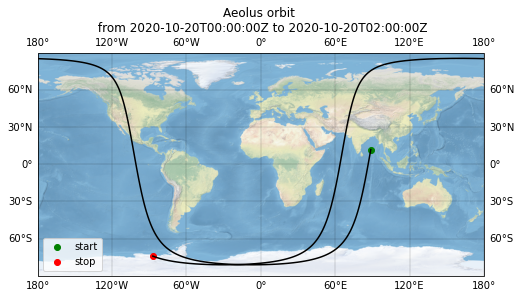

In [7]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.stock_img()
gl = ax.gridlines(draw_labels=True, linewidth=0.3, color="black", alpha=0.5, linestyle="-")
ax.plot(
    ds_observations["rayleigh_longitude"][:, -1],
    ds_observations["rayleigh_latitude"][:, -1],
    "k-",
    transform=ccrs.Geodetic(),
)
ax.scatter(
    ds_observations["rayleigh_longitude"][0, -1],
    ds_observations["rayleigh_latitude"][0, -1],
    marker="o",
    c="g",
    edgecolor="g",
    label="start",
    transform=ccrs.Geodetic(),
)
ax.scatter(
    ds_observations["rayleigh_longitude"][-1, -1],
    ds_observations["rayleigh_latitude"][-1, -1],
    marker="o",
    c="r",
    edgecolor="r",
    label="stop",
    transform=ccrs.Geodetic(),
)
ax.legend()
ax.set_title("Aeolus orbit \n from {} to {}".format(measurement_start, measurement_stop))

## Add datetime variable to the data sets

In [8]:
if "ds_measurements" in globals():
    ds_measurements["datetime"] = (
        ("measurement"),
        num2date(
            ds_measurements["time"], units="s since 2000-01-01", only_use_cftime_datetimes=False
        ),
    )
if "ds_observations" in globals():
    ds_observations["datetime"] = (
        ("observation"),
        num2date(
            ds_observations["time"], units="s since 2000-01-01", only_use_cftime_datetimes=False
        ),
    )

## Extract bits from bin_quality_flag and add them to the data sets for QC

In [9]:
if "ds_observations" in globals():
    ds_observations["rayleigh_validity_flags"] = (
        ("observation", "array_24", "array_16"),
        np.flip(
            np.unpackbits(
                ds_observations["rayleigh_bin_quality_flag"][:, :].values.view(np.uint8),
                bitorder="little",
            ).reshape([-1, 24, 16]),
            axis=-1,
        ),
    )
    ds_observations["mie_validity_flags"] = (
        ("observation", "array_24", "array_16"),
        np.flip(
            np.unpackbits(
                ds_observations["mie_bin_quality_flag"][:, :].values.view(np.uint8),
                bitorder="little",
            ).reshape([-1, 24, 16]),
            axis=-1,
        ),
    )

if "ds_measurements" in globals():
    ds_measurements["rayleigh_validity_flags"] = (
        ("measurement", "array_24", "array_16"),
        np.flip(
            np.unpackbits(
                ds_measurements["rayleigh_bin_quality_flag"][:, :].values.view(np.uint8),
                bitorder="little",
            ).reshape([-1, 24, 16]),
            axis=-1,
        ),
    )
    ds_measurements["mie_validity_flags"] = (
        ("measurement", "array_24", "array_16"),
        np.flip(
            np.unpackbits(
                ds_measurements["mie_bin_quality_flag"][:, :].values.view(np.uint8),
                bitorder="little",
            ).reshape([-1, 24, 16]),
            axis=-1,
        ),
    )

## Calculate additional parameters

In [10]:
# compute range corrected and normalized signal intensities
# compute range to bin center and range bin thickness
for parameter in ds_observations:
    if "range" in parameter:
        # range bin thickness
        ds_observations[parameter + "_bin_thickness"] = (
            ("observation", "array_24"),
            ds_observations[parameter].diff(dim="array_25").data,
        )
        # range to bin center
        range_to_bin_center = (
            ds_observations[parameter][:, 1:].data
            - 0.5 * ds_observations[parameter + "_bin_thickness"].data
        )
        ds_observations[parameter + "_to_bin_center"] = (
            ("observation", "array_24"),
            range_to_bin_center,
        )

# apply range correction and normalization by smallest possible range bin
# smallest range bin along line of sight is 315.407 meter

# range correction for observation level
if "ds_observations" in globals():        
    for parameter in ds_observations:
        if "signal_intensity" in parameter:
            obs_type = parameter.split("_")[0]
            signal_intensity_rc_normalized = (
                ds_observations[parameter].data[:, :-1]
                * (ds_observations[obs_type + "_range_to_bin_center"].data ** 2)
                * (315.407 / ds_observations[obs_type + "_range_bin_thickness"].data)
            )
            ds_observations[parameter + "_rc_normalized"] = (
                ("observation", "array_24"),
                signal_intensity_rc_normalized,
            )

# range correction for measurement level        
if "ds_measurements" in globals():
    for parameter in ds_measurements:
        if "signal_intensity" in parameter:
            obs_type = parameter.split("_")[0]
            signal_intensity_rc_normalized = (
                ds_measurements[parameter].data[:, :-1]
                * (ds_observations[obs_type + "_range_to_bin_center"].data.repeat(30, axis=0) ** 2)
                * (315.407 / ds_observations[obs_type + "_range_bin_thickness"].data.repeat(30, axis=0))
            )
            ds_measurements[parameter + "_rc_normalized"] = (
                ("measurement", "array_24"),
                signal_intensity_rc_normalized,
            )

## Plot parameter

### Curtain plot

In [11]:
# Define plot function
def plot_parameter_2D(
    parameter, x, y, level="observation", QC_filter=False, start_bin=0, end_bin=-1
):
    if level == "observation":
        ds = ds_observations
        # usual time difference between observations
        time_diff = 13.0
    elif level == "measurement":
        ds = ds_measurements
        # usual time difference between measurements is around 0.4 seconds
        # a larger gap is present at the end of 30 consecutive measurements forming one observation
        time_diff = 1.2

    # set profiles to nan where time differences are larger than one measurement or one observation
    # this is necessary to visualize gaps in pcolormesh
    parameter_data = np.copy(ds[parameter])
    parameter_data[:-1, :][np.diff(ds["time"], axis=0) > time_diff] = np.nan
    parameter_data[1:, :][np.diff(ds["time"], axis=0) > time_diff] = np.nan
    # filter range bins where the overall validity flag (bit 1 of bin quality flag) is 1
    if QC_filter:
        parameter_data[ds[parameter.split("_")[0] + "_validity_flags"][:, :, 0] == 1] = np.nan

    fig, ax = plt.subplots(1, 1, figsize=(10, 6), constrained_layout=True)
    im = ax.pcolormesh(
        ds[x][start_bin:end_bin],
        ds[y][start_bin:end_bin, :].T / 1000.0,
        parameter_data[start_bin : end_bin - 1, :].T,
        vmin=np.nanpercentile(parameter_data[start_bin:end_bin], 5),
        vmax=np.nanpercentile(parameter_data[start_bin:end_bin], 95),
    )
    ax.set_ylim(-1, 30)
    ax.set_xlabel("Date [UTC]")
    ax.set_ylabel("Altitude [km]")
    ax.set_title("{} - {} level".format(parameter, level))
    ax.grid()
    locator = mdates.AutoDateLocator(minticks=4, maxticks=8)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    fig.colorbar(im, ax=ax, aspect=50, pad=0.001)
    plt.figure()

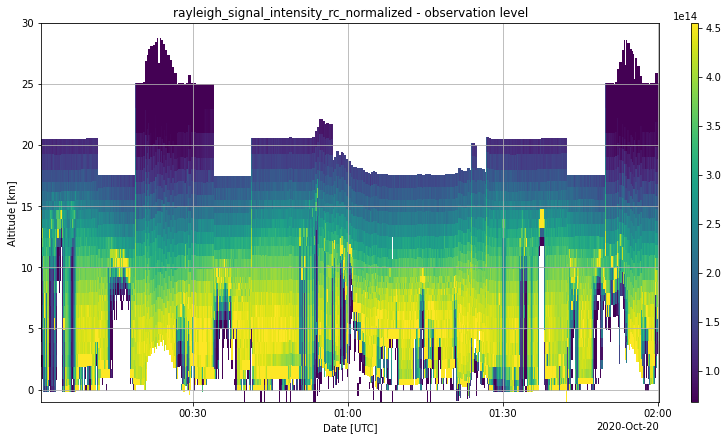

<Figure size 432x288 with 0 Axes>

In [12]:
# plot observation level
plot_parameter_2D(
    parameter="rayleigh_signal_intensity_rc_normalized",
    x="datetime",
    y="rayleigh_altitude",
    level="observation",
    QC_filter=True,
    start_bin=0,
    end_bin=-1,
)

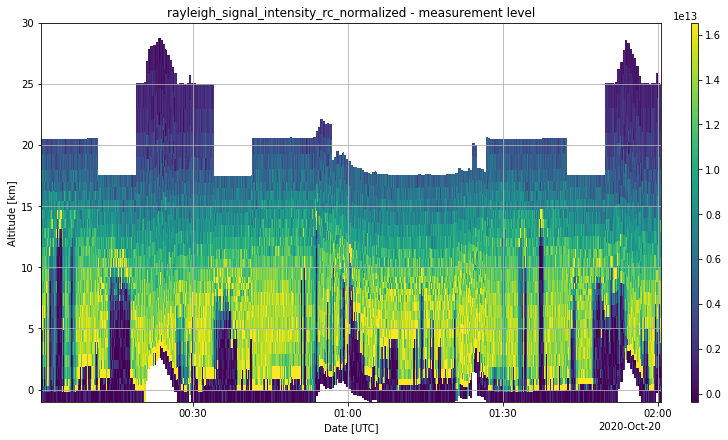

<Figure size 432x288 with 0 Axes>

In [13]:
# plot measurement level
plot_parameter_2D(
    parameter="rayleigh_signal_intensity_rc_normalized",
    x="datetime",
    y="rayleigh_altitude",
    level="measurement",
    QC_filter=False,
    start_bin=0,
    end_bin=-1,
)